## Importing libs

In [1]:
#From https://mne.tools/stable/auto_examples/simulation/simulate_raw_data.html#sphx-glr-auto-examples-simulation-simulate-raw-data-py
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne import Epochs, compute_covariance, find_events, make_ad_hoc_cov
from mne.datasets import sample
from mne.simulation import (
    add_ecg,
    add_eog,
    add_noise,
    simulate_raw,
    simulate_sparse_stc,
    
)
from mne.beamformer import apply_lcmv, make_lcmv
from mne.datasets import fetch_fsaverage, sample

### Loading data for experimental setup from mne sample


In [2]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fwd_fname = meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif"
subjects_dir = data_path / "subjects"
raw = mne.io.read_raw_fif(raw_fname).pick(["meg","stim"])
# noise_cov=mne.read_cov(meg_path / "sample_audvis-cov.fif")
subject = "sample"
annot = "aparc.a2009s"
sfreq =raw.info["sfreq"]
tstep = 1 /sfreq
fwd = mne.read_forward_solution(fwd_fname)
src = fwd["src"]


Opening raw data file /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.


Reading forward solution from /home/hp/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame


Opening raw data file /home/hp/mne_data/MNE-sample-data/MEG/sample/ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Using up to 550 segments
Number of samples used : 66000
[done]
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


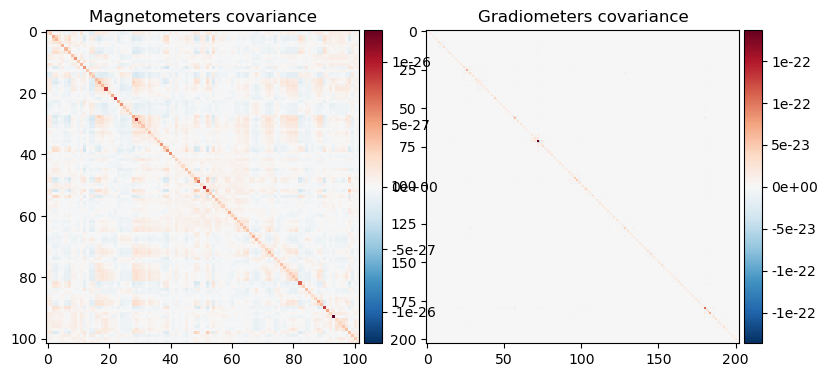

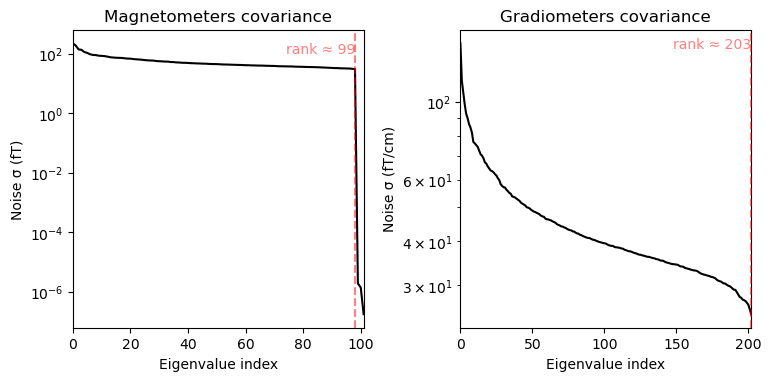

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [3]:
data_path = sample.data_path()
raw_empty_room_fname = data_path / "MEG" / "sample" / "ernoise_raw.fif"
raw_empty_room = mne.io.read_raw_fif(raw_empty_room_fname)
noise_cov = mne.compute_raw_covariance(raw_empty_room, tmin=0, tmax=None)
noise_cov.plot(raw_empty_room.info, proj=True)
#noise_cov_baseline.plot(epochs.info, proj=True)

## parameter setup

In [133]:
epoch_duration = 1  # duration of each epoch
times = raw.times[: int(raw.info["sfreq"] * epoch_duration)]
n_dipoles = 4 # number of dipoles to create
extent = 0.0 #exten=0 means a single dipole,  try to create a sequentially larger sources later
rng = np.random.RandomState(0)  # random state (make reproducible)


### Selecting the labels for vertices of dipoles


In [189]:
label_primary_aud_cortex = mne.read_labels_from_annot(
            subject, annot, subjects_dir=subjects_dir, regexp="G_temp_sup-G_T_transv-lh", verbose=False )# can also use G_occipital_middle-lh , G_temp_sup-G_T_transv-lh
label_primary_aud_cortex =   label_primary_aud_cortex*n_dipoles
vertices_in_aud_cortex =np.intersect1d(src[0]["vertno"], label_primary_aud_cortex[0].vertices) #
indices_in_label = np.where(np.isin(label_primary_aud_cortex[0].vertices, vertices_in_aud_cortex))[0]
print(f"Number of dipoles is {'lower/equal' if n_dipoles <= vertices_in_aud_cortex.shape[0] else 'higher'} than the total vertices in the label border")

label_dipole = []
saving_vertices=[]
for one_dipole in np.random.choice(indices_in_label,n_dipoles, replace=False): # Creating a label object for 
  # One dipole source                                          # each vertices, that can be passed down to simulator
    saving_vertices .append( label_primary_aud_cortex[0].vertices[one_dipole])
    label_dipole.append(mne.label.select_sources(
    subject,
    label_primary_aud_cortex[0],
    location=one_dipole,
    extent=extent,
    subjects_dir=subjects_dir,
    random_state=rng,           
    ))


Number of dipoles is lower/equal than the total vertices in the label border


In [190]:
# Visualisation of selected dipoles and label
brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title="Vertices in Aud Cortex Present in SOurce Space")
brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)
#brain.add_foci(vertices_in_aud_cortex,hemi="lh",coords_as_verts=True,color="red",scale_factor=0.2)
brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=True)

brain.add_foci(saving_vertices,hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=1)



## Defining wavelet function


In [149]:
## Function to make simple N100 like wavelet with damped sine
def simple_evoked(times):
    base_amplitude = 50e-9
    min_amplitude = 4e-8
    frequency = 7
    peak_time = 0.1
    std_dev = 0.003 * abs(np.random.randn(1))
    amplitude = max(min_amplitude, base_amplitude * abs(np.random.randn(1)))

    # Adjust phase shift to ensure sine wave has a negative peak at peak_time
    phase_shift = -np.pi / 2 - 2 * np.pi * frequency * peak_time
    sine_wave = np.sin(2 * np.pi * frequency * times + phase_shift)

    # Generate Gaussian envelope centered around peak_time
    gaussian_envelope = np.exp(-((times - peak_time ) ** 2) / std_dev)
    
    # Damped signal
    signal = amplitude * sine_wave * gaussian_envelope
    
    return signal



## Defining events and signal associated with each events , here one source will only have one kind of wave repeated at each trial

In [234]:
signal_matrix =  np.zeros((n_dipoles,times.shape[0]))
trials_no = 50
n_events = trials_no * n_dipoles
events = np.zeros((n_events, 3), int)

events[:, 0] = 100+400 * np.arange(n_events)  
for i in range(n_dipoles):
    signal_matrix[int(i),:]=np.sin(2.0 * np.pi * 7.0 * times) * 10e-9
    events[trials_no *(i):trials_no *(i+1), 2] = i+1
  
np.random.shuffle(events[:, 2])


    


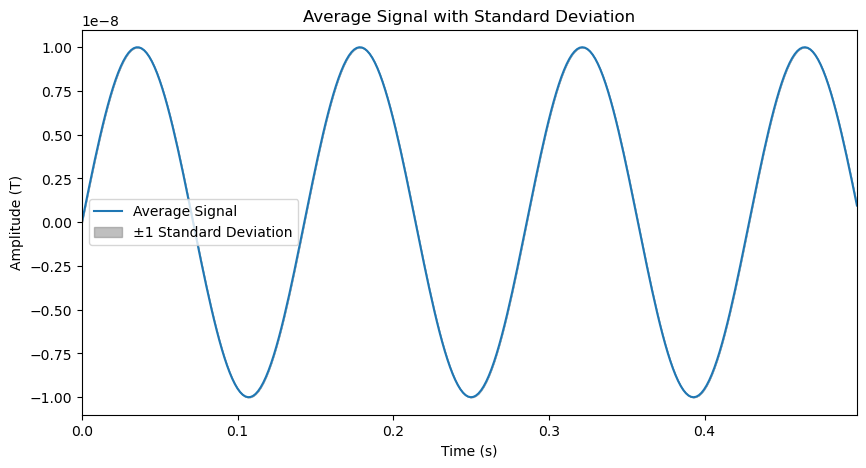

In [236]:
# epoch length is too long , change plot_samp when wavelet is wider to visualise betetr
plot_samp = 300
times_plot = times[:plot_samp]

average_signal = np.mean(signal_matrix[:, :plot_samp], axis=0)
std_signal = np.std(signal_matrix[:, :plot_samp], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(times_plot, average_signal, label='Average Signal')
plt.fill_between(times_plot, average_signal - std_signal, average_signal + std_signal, color='gray', alpha=0.5, label='±1 Standard Deviation')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (T)')
plt.title('Average Signal with Standard Deviation')
plt.legend()
plt.xlim([times_plot[0], times_plot[-1]])  # Adjust x-axis limits
plt.savefig('average_signal_with_std.png', dpi=400)
plt.show()

## Adding data to sourcesimulator object

In [237]:
source_simulator_dipole = mne.simulation.SourceSimulator(src, tstep=tstep)
for i in  range(n_dipoles):
    source_simulator_dipole.add_data(label_dipole[i], signal_matrix[i,:], events[events[:,2]==i+1])

    Created an SSP operator (subspace dimension = 3)


Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


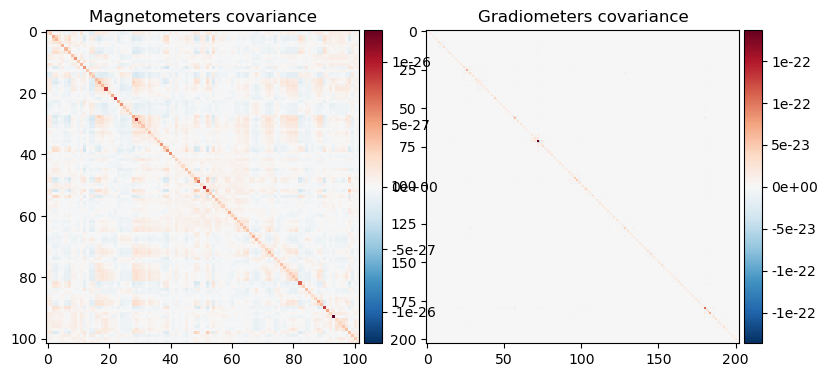

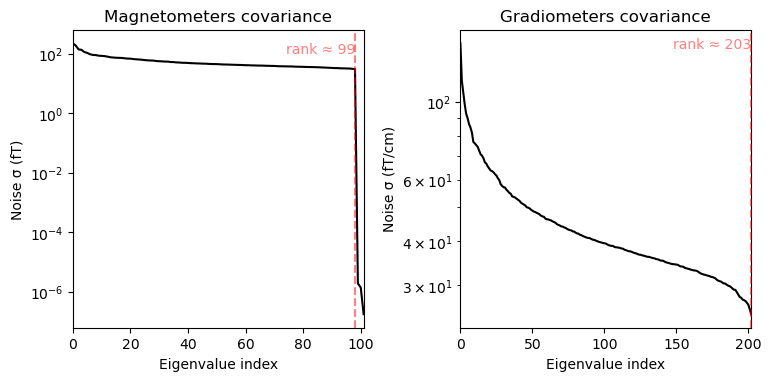

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [238]:
cov=noise_cov 
cov.plot(raw_empty_room.info, proj=True)


In [239]:
raw_empty_room.info["dev_head_t"] = raw.info["dev_head_t"]

In [240]:
raw_sim = mne.simulation.simulate_raw(raw_empty_room.info, source_simulator_dipole, forward=fwd)
raw_dipole = raw_sim.pick(picks=["meg", "stim"])
# cov = mne.make_ad_hoc_cov(raw_sim.info)
 # I am loading noise cov data from sample provided by mne
mne.simulation.add_noise(
    raw_dipole, cov, random_state=rng)  #iir_filter=[0.2, -0.2, 0.04]

Setting up raw simulation: 1 position, "cos2" interpolation
Event information stored on channel:              STI 014
    Interval 0.000–1.665 s
Setting up forward solutions
Computing gain matrix for transform #1/1
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
    Interval 0.000–1.665 s
  

Measurement date,"December 06, 2002 15:16:18 GMT"
Experimenter,neuromag
Participant,Unknown
Digitized points,Not available
Good channels,"203 Gradiometers, 102 Magnetometers, 9 Stimulus"
Bad channels,MEG 2443
EOG channels,Not available
ECG channels,Not available
Sampling frequency,600.61 Hz
Highpass,0.10 Hz
Lowpass,172.18 Hz


200 events found on stim channel STI 014
Event IDs: [1 2 3 4]


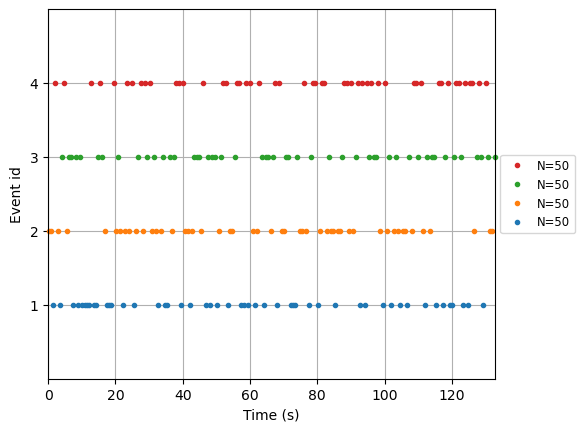

In [241]:
events = mne.find_events(raw_dipole, initial_event=True,min_duration=0)
fig = mne.viz.plot_events(
    events, sfreq=raw.info["sfreq"], first_samp=raw_sim.first_samp
)

## Saving evoked and epochs in a dict

In [246]:
epochs_dict = dict()
evoked_dict = dict()

for i in range(n_dipoles):
    epochs_dict[f'epoch_{i+1}']= mne.Epochs(raw_dipole, events, i+1, tmin=-0.1, tmax=2, baseline=(None,0.1))
    evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("meg").filter(l_freq=0.3, h_freq=20.0, picks=None, filter_length='auto',verbose=False)


Not setting metadata
50 matching events found
Setting baseline interval to [-0.09989760657919393, 0.1] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found
Setting baseline interval to [-0.09989760657919393, 0.1] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated


/tmp/ipykernel_147595/1625595358.py:6: RuntimeWarning: filter_length (6607) is longer than the signal (1262), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("meg").filter(l_freq=0.3, h_freq=20.0, picks=None, filter_length='auto',verbose=False)
/tmp/ipykernel_147595/1625595358.py:6: RuntimeWarning: filter_length (6607) is longer than the signal (1262), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("meg").filter(l_freq=0.3, h_freq=20.0, picks=None, filter_length='auto',verbose=False)


Not setting metadata
50 matching events found
Setting baseline interval to [-0.09989760657919393, 0.1] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated
Not setting metadata
50 matching events found


/tmp/ipykernel_147595/1625595358.py:6: RuntimeWarning: filter_length (6607) is longer than the signal (1262), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("meg").filter(l_freq=0.3, h_freq=20.0, picks=None, filter_length='auto',verbose=False)


Setting baseline interval to [-0.09989760657919393, 0.1] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
3 projection items activated


/tmp/ipykernel_147595/1625595358.py:6: RuntimeWarning: filter_length (6607) is longer than the signal (1262), distortion is likely. Reduce filter length or filter a longer signal.
  evoked_dict[f'epoch_{i+1}'] = epochs_dict[f'epoch_{i+1}'].average().pick("meg").filter(l_freq=0.3, h_freq=20.0, picks=None, filter_length='auto',verbose=False)


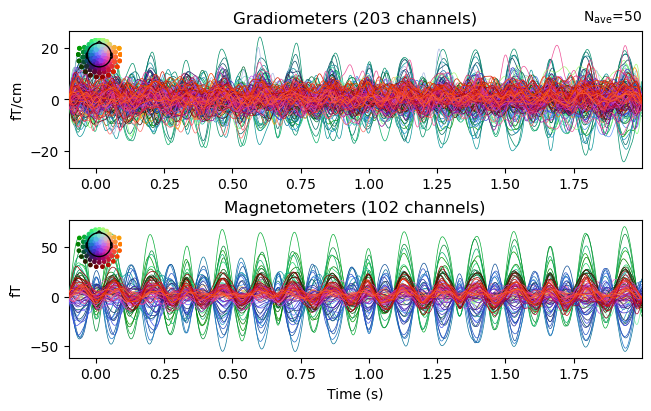

In [247]:
fig= evoked_dict["epoch_1"].plot()
fig.savefig('my_figure_evok.png')

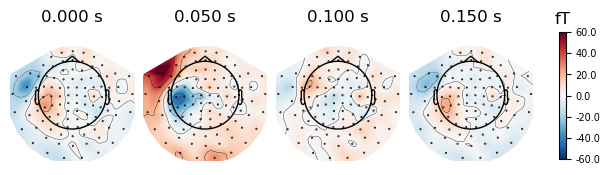

In [249]:
fig=evoked_dict["epoch_1"].plot_topomap(np.array([0.0,0.05,0.1,0.15]))
fig.savefig('my_figure_topo.png')

In [261]:
inverse_operator = make_inverse_operator(
    evoked_dict["epoch_1"].info, fwd, noise_cov, loose=0.2, depth=0.8
)
method = "MNE"
snr = 3.0
lambda2 = 1.0 / snr**2
stc, residual = apply_inverse(
    evoked_dict["epoch_1"],
    inverse_operator,
    lambda2,
    method=method,
    pick_ori=None,
    return_residual=True,
    verbose=True,
)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...


    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 366 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 305 dim * 2.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.27819
    scaling factor to adjust the trace = 5.44775e+19 (n

In [262]:
vertno_max, time_max = stc.get_peak(hemi="lh")

subjects_dir = data_path / "subjects"
surfer_kwargs = dict(
    hemi="lh",
    subjects_dir=subjects_dir,
    clim=dict(kind="value", lims=[8, 12, 15]),
    views="lateral",
    initial_time=time_max,
    time_unit="s",
    size=(800, 800),
    smoothing_steps=10,
)
brain = stc.plot(**surfer_kwargs)

OverflowError: argument 1 overflowed: value must be in the range -2147483648 to 2147483647

In [263]:
vertno_max, saving_vertices[0]

(124379, 89253)

# Inverse modelling

In [202]:
from mne.minimum_norm import apply_inverse, make_inverse_operator,apply_inverse_epochs

# Dipole
snr = 3.0
inv_methods_list = ['MNE',"dSPM"]
lambda2 = 1.0 / snr**2
inv_meth_dict = dict()

In [205]:
for inv_method in inv_methods_list: #Probably use another way to store data later if there are 100s of sources, rather than dict of dict
    stc_est_dipole_dict=dict()      # Also change i and j in all loops 
    peak_dict = dict()

    for i,j in evoked_dict.items():
        inverse_operator = make_inverse_operator(raw_empty_room.info, fwd, cov, loose="auto", depth=0.8,fixed=True)
        stc_est_dipole_dict[i] = apply_inverse(j, inverse_operator, lambda2, inv_method, pick_ori=None,method_params={"max_iter":100})
        peak_dict[i] = stc_est_dipole_dict[i].get_peak(hemi="lh")[0]

    inv_meth_dict[f"{inv_method}"] = {"peak_coord":peak_dict,"stc_est_dict":stc_est_dipole_dict}


info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.


    305 out of 366 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020866
    scale = 2.58122e-08 exp = 0.8
    Picked elements from a free-orientation depth-weighting prior into the fixed-orientation one
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 305 dim * 2.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.31701


    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


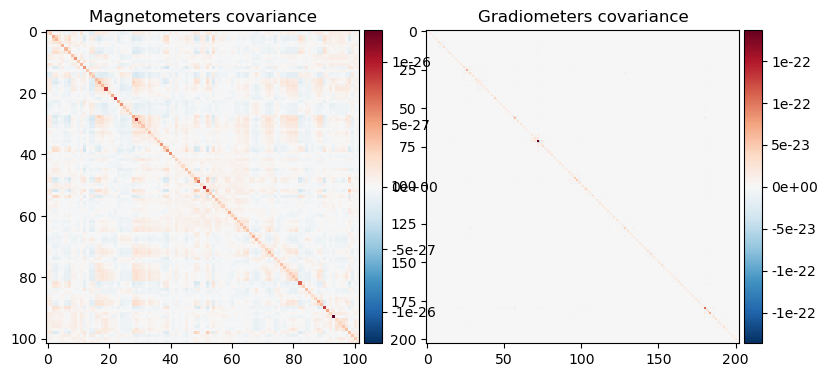

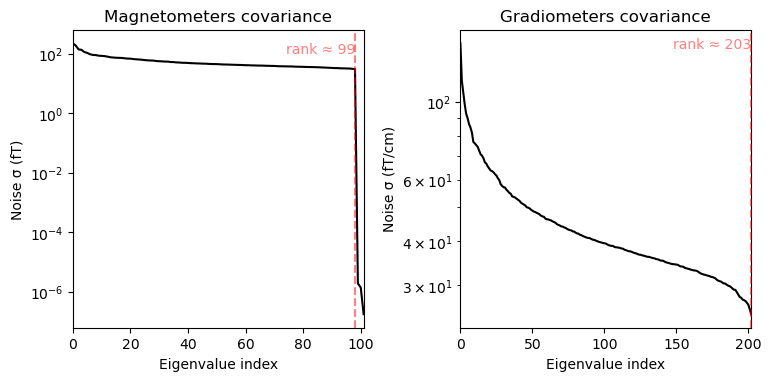

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

In [175]:
cov.plot(raw_empty_room.info, proj=True)


In [206]:
mismatched_dict=dict()
for inv_method in inv_methods_list:
    peak_dict = inv_meth_dict[inv_method]["peak_coord"]

    brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title=f"{inv_method}Vertices in Aud Cortex Present in SOurce Space")

    correct=(np.array(list(peak_dict.values())) ==np.array(saving_vertices))

    brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)

    brain.add_foci(np.array(saving_vertices)[correct],hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=0.3)
    brain.add_foci(
    np.array(list(peak_dict.values())),
    coords_as_verts=True,
    hemi="lh",

    color="red",
    scale_factor=0.4,
    alpha=0.1,
    )

    mismatched_dict[inv_method]=np.array((saving_vertices,list(peak_dict.values()))).T


    brain.add_foci(np.array(saving_vertices)[np.invert(correct)],hemi="lh",coords_as_verts=True,color="black",scale_factor=0.2)

    brain.add_label(
        label_dipole[0], hemi="lh", color="orange", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=False)

    brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=True)



In [185]:
import pandas as pd
import numpy as np

# List of depth parameters
depth_parameters = np.linspace(0.8,1,10)

# Initialize a DataFrame to store the results
results_df = pd.DataFrame(columns=['depth', 'inv_method', 'source', 'correct_position', 'measured_position', 'match'])

# Iterate over the list of depth parameters
for depth in depth_parameters:
    for inv_method in inv_methods_list:
        stc_est_dipole_dict = dict()
        peak_dict = dict()
        
        for source, evoked in evoked_dict.items():
            inverse_operator = make_inverse_operator(raw_empty_room.info, fwd, cov, loose=0.2, depth=depth, fixed="auto")
            stc_est_dipole_dict[source] = apply_inverse(evoked, inverse_operator, lambda2, inv_method, pick_ori=None, method_params={"max_iter":100})
            peak_dict[source] = stc_est_dipole_dict[source].get_peak(hemi="lh")[0]
        
        inv_meth_dict[inv_method] = {"peak_coord": peak_dict, "stc_est_dict": stc_est_dipole_dict}
        
         # Prepare a list to store new rows
        new_rows = []
        

        new_rows.append({
            'depth': depth,
            'inv_method': inv_method,
            'correct_position': saving_vertices,
            'measured_position':  np.array(list(peak_dict.values())),
            'match': saving_vertices == np.array(list(peak_dict.values()))
        })
    
        # Convert the list of new rows to a DataFrame and concatenate it with the results DataFrame
        new_rows_df = pd.DataFrame(new_rows)
        results_df = pd.concat([results_df, new_rows_df], ignore_index=True)

# Display the results DataFrame
print(results_df)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...


    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 305 channels.
    305 out of 366 channels remain after picking
Selected 305 channels
Creating the depth weighting matrix...
    203 planar channels
    limit = 7262/7498 = 10.020865
    scale = 2.58122e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.5e-13 (2.2e-16 eps * 305 dim * 2.2  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 6.27819
    scaling factor to adjust the trace = 5.44775e+19 (n

In [ ]:
brain.save_image("mne_placeholder_inv_image_.png")

In [186]:
results_df

,depth,inv_method,source,correct_position,measured_position,match
0,0.800000,MNE,NaN,"[41031, 48879, 46419, 63896]","[34712, 45190, 45048, 62558]","[False, False, False, False]"
1,0.800000,dSPM,NaN,"[41031, 48879, 46419, 63896]","[43741, 42571, 42571, 65208]","[False, False, False, False]"
2,0.822222,MNE,NaN,"[41031, 48879, 46419, 63896]","[34712, 45190, 45048, 62558]","[False, False, False, False]"
3,0.822222,dSPM,NaN,"[41031, 48879, 46419, 63896]","[43741, 42571, 42571, 65208]","[False, False, False, False]"
4,0.844444,MNE,NaN,"[41031, 48879, 46419, 63896]","[34712, 45190, 45048, 62558]","[False, False, False, False]"
5,0.844444,dSPM,NaN,"[41031, 48879, 46419, 63896]","[43741, 42571, 42571, 65208]","[False, False, False, False]"
6,0.866667,MNE,NaN,"[41031, 48879, 46419, 63896]","[34712, 45190, 45048, 62558]","[False, False, False, False]"
7,0.866667,dSPM,NaN,"[41031, 48879, 46419, 63896]","[43741, 42571, 42571, 65208]","[False, False, False, False]"
8,0.888889,MNE,NaN,"[41031, 48879, 46419, 63896]","[34712, 55793, 45048, 62558]","[False, False, False, False]"
9,0.888889,dSPM,NaN,"[41031, 48879, 46419, 63896]","[43741, 42571, 42571, 65208]","[False, False, False, False]"


In [183]:
[sum(i) for i in results_df.match]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [187]:
for depth in depth_parameters:
    peak_dict = results_df[results_df.depth == depth].measured_position.values[0]

    brain_kwargs = dict(alpha=0.2, background="white", cortex="low_contrast",title=f"{depth}")

    correct= np.array(results_df[results_df.depth == depth].correct_position.values[0])
    print(correct)
    brain = mne.viz.Brain("sample", subjects_dir=subjects_dir, **brain_kwargs)

    brain.add_foci(correct,hemi="lh",coords_as_verts=True,color="blue",scale_factor=0.2,alpha=0.3)
    brain.add_foci(
    peak_dict,
    coords_as_verts=True,
    hemi="lh",

    color="red",
    scale_factor=0.4,
    alpha=0.1,
    )



    brain.add_foci(correct,hemi="lh",coords_as_verts=True,color="black",scale_factor=0.2)

    brain.add_label(
        label_dipole[0], hemi="lh", color="orange", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=False)

    brain.add_label(
        label_primary_aud_cortex[0], hemi="lh", color="green", subdir="/home/hp/mne_data/MNE-sample-data/subjects/fsaverage/label/lh.aparc.a2009s",borders=True)



[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]
[41031 48879 46419 63896]


In [112]:
peak_dict = results_df[results_df.depth == depth].measured_position.values[0]


In [113]:
peak_dict

array([ 87987,  70838,  97331,  73155,  70838,  93922,  73155,  70838,
        87987, 106609,  74333,  87987,  93922, 103333, 103333, 103333,
        86834,  86834,  87987])